# Identify buildings from DSM data

To open this notebook with Google Colab, click on the following link:

[Open in Google Colab](https://colab.research.google.com/github/sogelink-research/ML-Course/blob/main/notebooks/1-introduction_shorter/building_classification.ipynb)

## Import necessary stuff for Google Colab

In [1]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

Import the necessary files if running in Google Colab.

In [2]:
if IN_COLAB:
    import urllib.request
    import zipfile
    from pathlib import Path
    from shutil import copy, copytree, rmtree

    # Download the GitHub repository
    zip_path = Path("simple_model.zip")
    directory_path = Path(".")
    initial_simple_model_path = Path(
        "ML-Course-main/notebooks/1-introduction_shorter/simple_model"
    )
    simple_model_path = Path("simple_model")

    url = "https://github.com/sogelink-research/ML-Course/archive/refs/heads/main.zip"
    urllib.request.urlretrieve(url, zip_path)

    # Unzip the repository
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(directory_path)

    # Take the files from the simple model
    copytree(
        initial_simple_model_path,
        simple_model_path,
        copy_function=lambda s, d: not Path(d).exists() and copy(s, d),
        dirs_exist_ok=True,
    )

    # Take the requirements
    initial_requirements_path = Path(
        "ML-Course-main/notebooks/1-introduction_shorter/requirements.txt"
    )
    requirements_path = Path("requirements.txt")
    copy(initial_requirements_path, requirements_path)

    # Clean the rest
    zip_path.unlink()
    rmtree(Path("ML-Course-main"))

    def get_files(path: Path, extensions: list[str]):
        all_files = []
        for ext in extensions:
            all_files.extend(path.glob(f"*.{ext}"))
        return all_files

    for file_path in get_files(directory_path, ["py", "just"]):
        file_path.unlink()

    print("Downloaded the necessary files")

Install the necessary packages if running in Google Colab.

In [3]:
if IN_COLAB:
    %pip install -r requirements.txt

## Import the necessary libraries

In [4]:
from pathlib import Path

from simple_model.bbox import BboxInt
from simple_model.dataloader import ImagesLoader
from simple_model.dataparse import download_all, tile_image
from simple_model.nn import SegmentationConvolutionalNetwork, get_new_model_name

## Define the parameters

| Name | Type | Possible values | Description | Advice |
| ---- | ---- | --------------- | ----------- | ------------ |
| minx, maxy, maxx, miny | **integers** | Coordinates in EPSG:7415 in the Netherlands. | Coordinates of the bounding box of the area that will be used to train the model | Larger area means more data so potentially better final model but longer to train. |
| filter_buildings | boolean | Any | Whether to filter out small buildings in the dataset (area < 30m² and "gebruiksdoel" undefined). | Keep it true. |
| image_size | integer | > 0 | Size of the images processed by the model (they will be (image_size×image_size)). | Since the image size is divided multiple times by 2, it is necessary to use a multiple of 2 with high-enough multiplicity. |
| nodata | float | Any | Value to replace NO_DATA with. | This value will be used to replace any missing pixel, mainly water but also potential holes in the data in buildings, roads, etc. |
| encoder_channels | list of integers | > 0 | Number of channels in the successive steps of the encoder. This also defines the number of steps. | More channels mean larger model with longer training and running time, but potentially better capabilities. Usually, the values inside are increasing, to capture more and more features at each step. |
| layers_downsample | integer | > 0 | Number of convolutional layers each step the encoder. | More layers should be able to extract more information, at the cost of a larger model. |
| layers_upsample | integer | > 0 | Number of convolutional layers each step the decoder. | More layers should be able to better combiner information, at the cost of a larger model. |
| batch_size | integer | > 0 | Size of the batches (number of images processed at once). | Larger batches mean more images processed before each training step, meaning less steps per epoch, but potentially "better" steps thanks to processing more images. The available memory of the GPU, in relation to the other parameters, define the maximum possible value for a given model and a given GPU. |
| train_proportion | float | Between 0 and 1 | Proportion of the data used for training. The rest is used for validation during training, to assess the current model on data that it wasn't trained on. | You usually want to use most of the data for training, but still want enough to get a decent evaluation. |
| optimizer_type | string | "adam" or "sgd" | Type of optimizer used to train the model. | Adam is usually a good choice for most models. |
| initial_learning_rate | float | > 0 | Initial learning rate of the optimizer. | A larger value means faster training but also more risk of not converging to a good solution. The value highly depend on the other parameters, like the size of the model or the batch size, but usually values from 0.0001 to 0.01 are used. |
| max_epochs | integer | > 0 | Maximum number of iterations to train the model. Each iteration goes through the whole dataset. | You usually want this value to be high enough for the model to be as optimised as possible. Here you can interrupt the training when you want, but this can be an important parameter when training a model without monitoring the process. |
| stop_early_after | integer | > 0 | Number of epochs without improvement before stopping the training. Prevents running for all the given epochs when the model doesn't seem to be improving any more. | A larger value prevents stopping too early if the model could still improve despite temporarily not improving. But it also means that the training won't stop as early if the model is really stuck. |


To view the data online and select one or multiple areas to work on, you can use:

- This website to view the data and select coordinates (using the "Measurements" tool) in the bottom right: <https://app.ellipsis-drive.com/view?pathId=78080fff-8bcb-4258-bb43-be9de956b3e0>
- This website to convert coordinates to EPSG:7415: <https://epsg.io/transform#s_srs=4326&t_srs=7415&x=NaN&y=NaN>

In [5]:
# ------------------------------ Data selection ------------------------------ #
minx_miny_maxx_maxy = [
    (120000, 482000, 125000, 487000),
    (157000, 475000, 162000, 480000),
]  # Coordinates of the areas of interest (minx, maxy, maxx, miny)
filter_buildings = True  # True to filter small buildings

# ----------------------------- Data preparation ----------------------------- #
image_size = 512  # Size of the images processed by the model
nodata = -10  # Value to replace nodata with

# ----------------------------- Model parameters ----------------------------- #
encoder_channels = [16, 32, 64]  # Number of channels in the encoder and decoder
layers_downsample = 2  # Number of convolutional layers in the encoder
layers_upsample = 2  # Number of convolutional layers in the decoder

# ---------------------------- Training parameters --------------------------- #
batch_size = 12  # Size of the batches (number of images processed at once)
train_proportion = 0.8  # Proportion of the data used for training

optimizer_type = "adam"  # Type of optimizer to use ("adam" or "sgd")
initial_learning_rate = 0.01  # Initial learning rate for the optimizer
max_epochs = 200  # Maximum number of iterations to train the model
stop_early_after = (
    10  # Number of epochs without improvement before stopping the training
)

## Download the training data

In [6]:
# # Create the bounding box
# bbox = BboxInt(minx, maxy, maxx, miny, True)

# Create the bounding boxes
bboxes = [
    BboxInt(minx, miny, maxx, maxy, True)
    for (minx, miny, maxx, maxy) in minx_miny_maxx_maxy
]

# Download the data
main_data_folder = Path("data")
main_models_folder = Path("models")

main_data_folder.mkdir(parents=True, exist_ok=True)
main_models_folder.mkdir(parents=True, exist_ok=True)

data_folders = []
full_image_paths = []
full_mask_paths = []
for bbox in bboxes:
    # Download the data
    print(f"Downloading data for {bbox}")
    data_folder, full_image_path, full_mask_path = download_all(
        bbox, main_data_folder, filter_buildings
    )
    data_folders.append(data_folder)
    full_image_paths.append(full_image_path)
    full_mask_paths.append(full_mask_path)

Filtering buildings... Skipped because file already exists.
Creating mask from data/120000_482000_125000_487000/buildings_filtered/buildings.geojson... Skipped because file already exists.
Filtering buildings... Skipped because file already exists.
Creating mask from data/157000_475000_162000_480000/buildings_filtered/buildings.geojson... Skipped because file already exists.


## Prepare the data

In [7]:
# Tile the images and masks
images_paths = []
masks_paths = []
for full_image_path in full_image_paths:
    images_path = tile_image(full_image_path, tile_size=image_size)
    images_paths.append(images_path)

for full_mask_path in full_mask_paths:
    masks_path = tile_image(full_mask_path, tile_size=image_size)
    masks_paths.append(masks_path)

# Create the images loader
image_shape = (image_size, image_size)
images_loader = ImagesLoader(image_shape=image_shape, nodata=nodata)
for data_folder, images_path, masks_path in zip(
    data_folders, images_paths, masks_paths
):
    images_loader.load_data(data_folder, images_path, masks_path)

Creating tiles from data/120000_482000_125000_487000/dsm/merged.tif... Skipped because folder already exists.
Creating tiles from data/157000_475000_162000_480000/dsm/merged.tif... Skipped because folder already exists.
Creating tiles from data/120000_482000_125000_487000/mask_filtered/merged.tif... Skipped because folder already exists.
Creating tiles from data/157000_475000_162000_480000/mask_filtered/merged.tif... Skipped because folder already exists.


## Initialise the model

/home/alexandre/Documents/Geodan/ML-Course/notebooks/1-introduction_shorter/simple_model/model_plotting.py:85: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle(


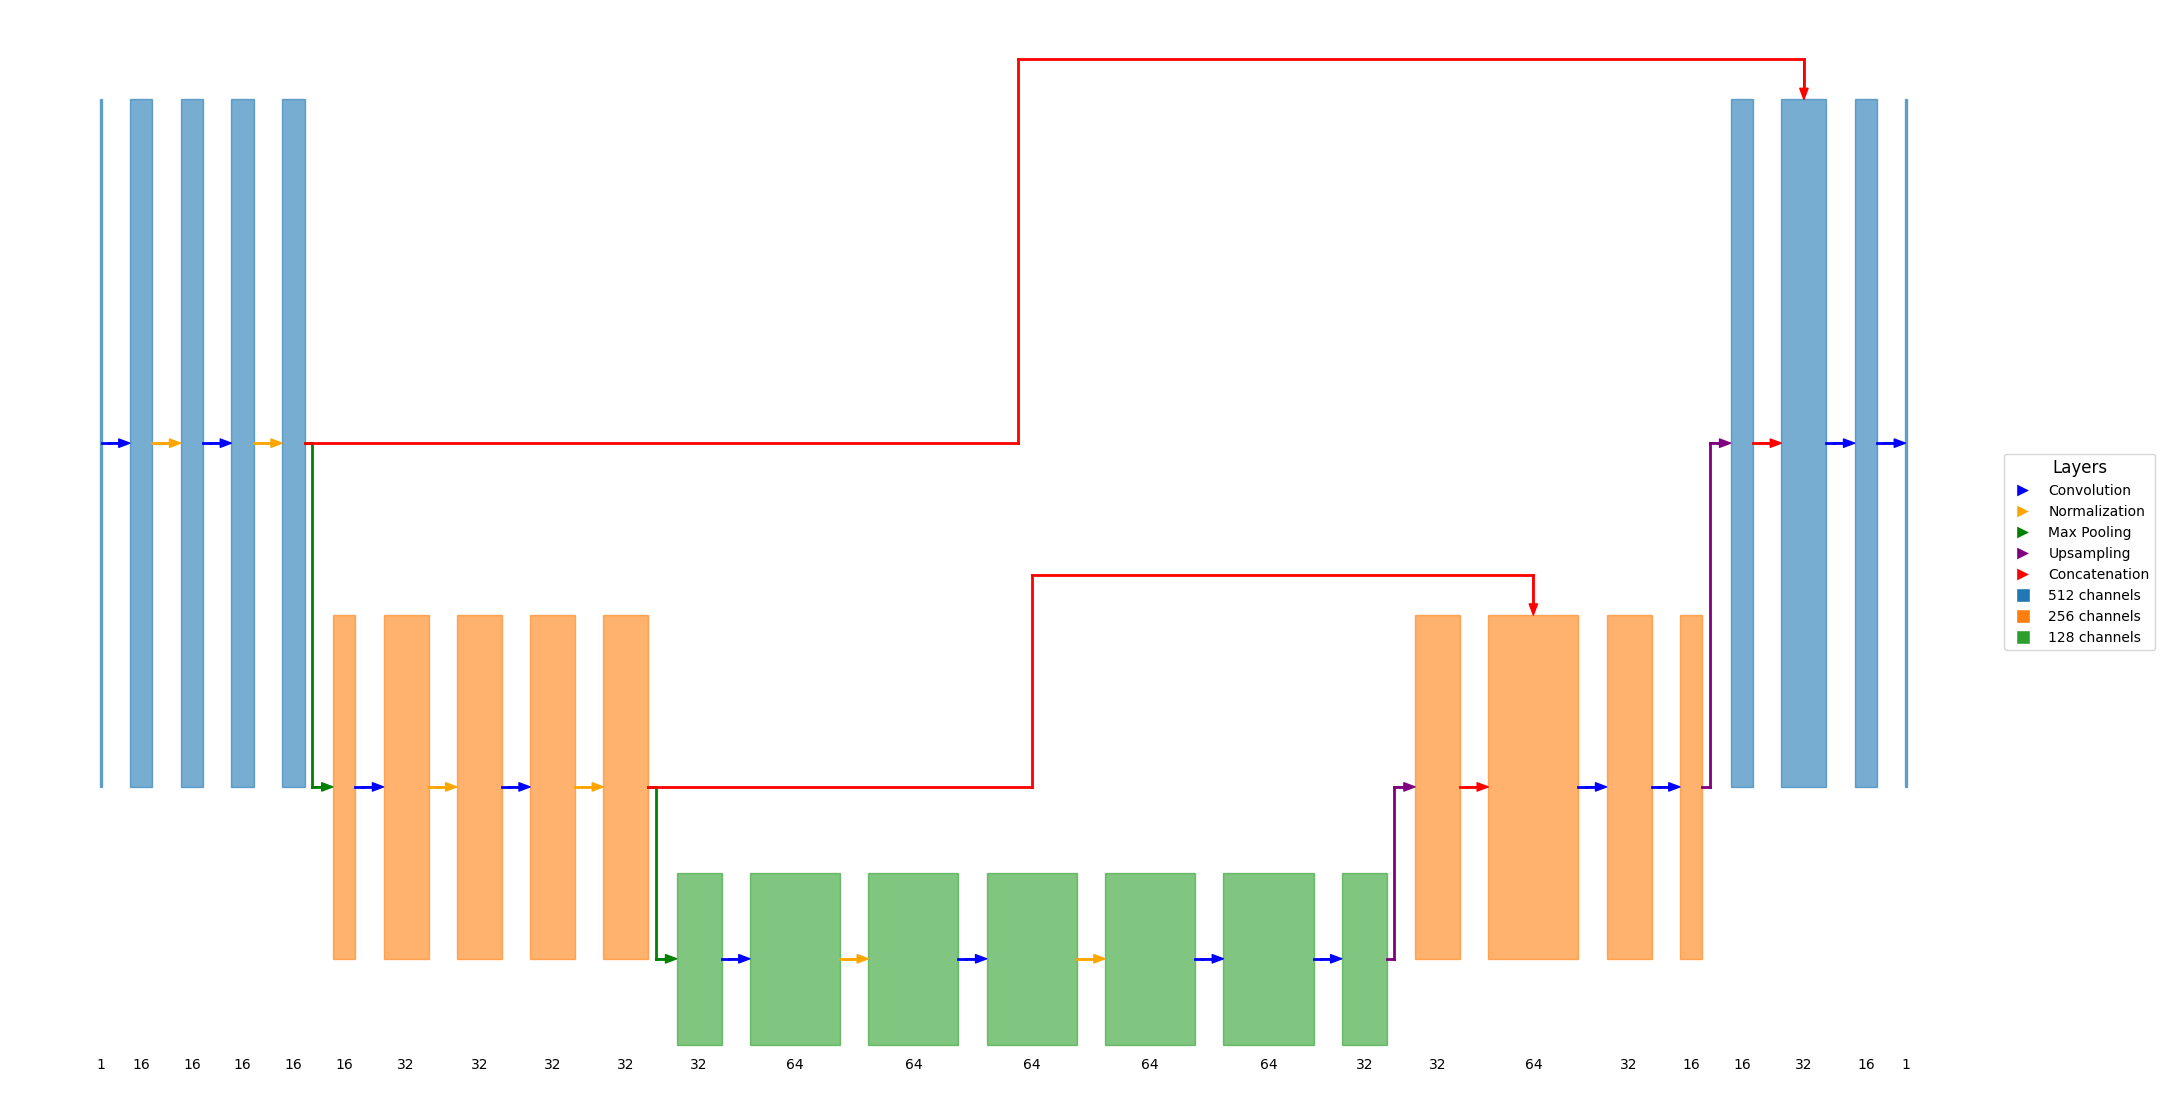

In [8]:
model_name = get_new_model_name()
model_folder = main_models_folder / model_name
model_folder.mkdir(parents=True, exist_ok=True)
model = SegmentationConvolutionalNetwork(
    image_shape=image_shape,
    encoder_channels=encoder_channels,
    layers_downsample=layers_downsample,
    layers_upsample=layers_upsample,
    input_channels=1,
    model_folder=model_folder,
    data_folders=data_folders,
)

# # Better speed for CPU
# torch.compile(model)
model.plot_model()

## Train the model

In [9]:
# Create the dataloaders with proper configuration
train_val_dataloaders = images_loader.get_dataloaders(
    batch_size=batch_size, train_proportion=train_proportion
)

Number of images: 800


In [10]:
# Train the model
model.train_model(
    dataloaders=train_val_dataloaders,
    max_epochs=max_epochs,
    optimizer_type=optimizer_type,
    initial_learning_rate=initial_learning_rate,
    stop_early_after=stop_early_after,
    save_weights=True,
)

Training the model...
Using the following device: cuda


  0%|          | 0/200 [00:00<?, ?it/s]

Output()

/home/alexandre/Documents/Geodan/ML-Course/notebooks/1-introduction_shorter/simple_model/metrics.py:25: RuntimeWarning: invalid value encountered in divide
  return np.where(tp + fp == 0, 1.0, tp / (tp + fp))
/home/alexandre/Documents/Geodan/ML-Course/notebooks/1-introduction_shorter/simple_model/metrics.py:25: RuntimeWarning: invalid value encountered in scalar divide
  return np.where(tp + fp == 0, 1.0, tp / (tp + fp))
/home/alexandre/Documents/Geodan/ML-Course/notebooks/1-introduction_shorter/simple_model/visualisation.py:313: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(start - x_margin, end + x_margin)


KeyboardInterrupt: 

## Test the model

In [ ]:
# Compute and save the model predictions
output_folder = model_folder / "output"
model.save_predictions(
    images_loader=images_loader,
    dataloaders=train_val_dataloaders,
    output_folder=output_folder,
)

# Compute and save the model metrics
metrics_folder = model_folder / "metrics"
model.save_metrics(
    images_loader=images_loader,
    dataloaders=train_val_dataloaders,
    metrics_folder=metrics_folder,
)

## Zip the results to download locally

In [ ]:
# Zip the model folder
if IN_COLAB:
    import shutil

    shutil.make_archive(
        model_folder, "zip", root_dir=model_folder.parent, base_dir=model_folder.name
    )
    print(f"Model saved at {model_folder}.zip")

## Load a previously trained model

In [ ]:
# model_folder = Path("models/250409_232909")
# model = SegmentationConvolutionalNetwork.load_model(model_folder=model_folder)